In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import glob
import pickle
import pandas as pd
import pyccl as ccl
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import pyccl as ccl
import clmm
from scipy import stats
from clmm import Cosmology

def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/likelihood/')
import model_completeness as comp
import model_purity as pur
import model_cluster_abundance as cl_count
import model_stacked_cluster_mass as cl_mass

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/modules/')
import class_richness_mass_relation as rm_relation

sys.path.append('/pbs/throng/lsst/users/cpayerne/capish/pinocchio/')
import pinocchio_mass_richness_relation as sim_mr_rel
import pinocchio_binning_scheme as binning_scheme

In [2]:
log10m0, z0 = sim_mr_rel.log10m0, sim_mr_rel.z0
proxy_mu0, proxy_muz, proxy_mulog10m =  sim_mr_rel.proxy_mu0, sim_mr_rel.proxy_muz, sim_mr_rel.proxy_mulog10m
proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m =  sim_mr_rel.proxy_sigma0, sim_mr_rel.proxy_sigmaz, sim_mr_rel.proxy_sigmalog10m
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]
sigma_wl_log10mass = 0.25/np.log(10)#sim_mr_rel.sigma_wl_log10mass
RM1 = rm_relation.Richness_mass_relation()
RM1.select(which = 'log_normal_poisson_scatter')

In [3]:
RM2 = rm_relation.Richness_mass_relation()
RM2.select(which = 'log_normal')

In [4]:
richness_grid = np.logspace(np.log10(0.0000001), np.log10(200), 310)

In [5]:
theta_rm = [log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m]

In [6]:
z = 0.5

In [7]:
from scipy.stats import poisson

In [8]:
def pdf_richness_mass_relation_GPC(richness, logm, z, theta_rm):
    log10m0, z0, proxy_mu0, proxy_muz, proxy_mulog10m, proxy_sigma0, proxy_sigmaz, proxy_sigmalog10m = theta_rm
    proxy_mu = RM1.proxy_mu_f(logm, z, theta_rm)
    proxy_sigma = RM1.proxy_sigma_f(logm, z, theta_rm)
    proxy_sigma2 = proxy_sigma**2  
    proxy_sigma = proxy_sigma2**.5
    
    mu_mean = np.exp(proxy_mu)
    rv = poisson(mu_mean)
    mu_mean_k = np.arange(1000)
    proba = rv.pmf(mu_mean_k)
    
    y = np.zeros(len(richness_grid))
    for i in range(len(proba)):
        y += proba[i] * np.exp(-(np.log(richness)-np.log(mu_mean_k[i]))**2/(2*proxy_sigma**2))/np.sqrt(2*np.pi*proxy_sigma**2) 

    return y

/tmp/ipykernel_18259/2426159497.py:15: RuntimeWarning: divide by zero encountered in log
  y += proba[i] * np.exp(-(np.log(richness)-np.log(mu_mean_k[i]))**2/(2*proxy_sigma**2))/np.sqrt(2*np.pi*proxy_sigma**2)


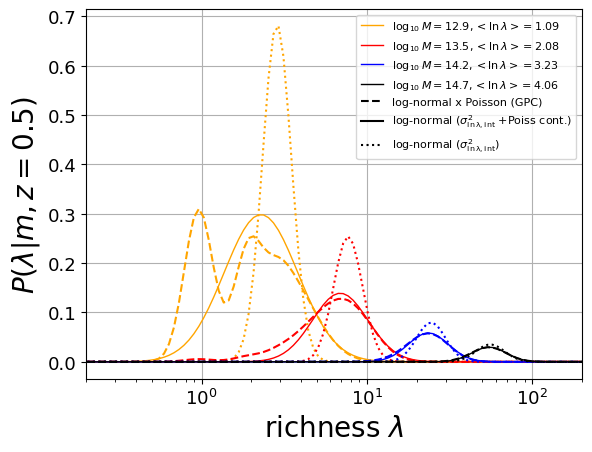

In [9]:
color = ['orange', 'r','b','k']
for i, logm in enumerate([12.9, 13.5, 14.2, 14.7]):
    y_log_normal_poisson_log_scatter = richness_grid* RM1.pdf_richness_mass_relation(richness_grid, logm, z, theta_rm)
    y_log_normal_poisson = richness_grid * RM2.pdf_richness_mass_relation(richness_grid, logm, z, theta_rm)
    y_log_normal_poisson_scatter = pdf_richness_mass_relation_GPC(richness_grid, logm, z, theta_rm)
    mu_lnlambda = RM1.proxy_mu_f(logm, z, theta_rm)
    plt.plot(np.exp(np.log(richness_grid)), y_log_normal_poisson_log_scatter/richness_grid, ls='-', lw=1, color = color[i], 
             label = r'$\log_{10}M =$' +f'$ {logm:.1f}, <\ln \lambda> = {mu_lnlambda:.2f}$')
    plt.plot(np.exp(np.log(richness_grid)), y_log_normal_poisson_scatter/richness_grid, '--', color = color[i])
    plt.plot(np.exp(np.log(richness_grid)), y_log_normal_poisson/richness_grid, ls='dotted', color = color[i])
    plt.xscale('log')
plt.xlim(2e-1,200)
plt.tick_params(axis='both', which = 'major', labelsize= 13)
plt.plot([], [], 'k', ls='--', label = 'log-normal x Poisson (GPC)')
plt.plot([], [], 'k', ls='-', label = r'log-normal $(\sigma_{\rm \ln\lambda, int}^2$ +Poiss cont.)')
plt.plot([], [], 'k',ls='dotted', label = r'log-normal $(\sigma_{\rm \ln\lambda, int}^2$)')
plt.legend(fontsize=8)
plt.ylabel(r'$P(\lambda|m,z=0.5)$', fontsize=20)
plt.xlabel(r'richness $\lambda$', fontsize=20)
plt.grid()
#plt.savefig(f'/pbs/throng/lsst/users/cpayerne/capish/figures/impact_poisson_scatter_mass-richness_relation.png', dpi = 300, bbox_inches='tight', )